H20 is a library which provides several widely-accepted ML algorithms. 
```
You just apply these ML algorithms on-by-one manually
OR
Apply all of them together using AutoML (automatic training and tuning)
```

# Import Libraries

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [2]:
!pip install h2o==3.30.0.1

     |████████████████████████████████| 129.5MB 61kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.1-py2.py3-none-any.whl size=129557718 sha256=445974b1b996098a390a81d31d5bc76eb64d5697ce24fa71c2e22d53c3650df7
  Stored in directory: /root/.cache/pip/wheels/db/42/63/d118d7218432054da842f5d10bd4f99e978bde0931164e6c7a
Successfully built h2o


In [3]:
import tensorflow_datasets as tfds
import h2o
import numpy as np
import nltk
from nltk.corpus import stopwords
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators import H2OGradientBoostingEstimator, H2OXGBoostEstimator
from h2o.automl import H2OAutoML

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnu4f15xp
  JVM stdout: /tmp/tmpnu4f15xp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnu4f15xp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,"1 year, 1 month and 1 day !!!"
H2O_cluster_name:,H2O_from_python_unknownUser_sh9ykk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


# Dataset Preparation

In [5]:
# load dataset
dataset, info = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', with_info=True, batch_size=-1)
train_dataset = dataset['train']

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0.incomplete7N3WX2/amazon_us_reviews-train.tfrecord


Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [7]:
# convert data type
dataset=tfds.as_numpy(train_dataset)

# feature selection
helpful_votes=dataset['data']['helpful_votes']
review_headline=dataset['data']['review_headline']
review_body=dataset['data']['review_body']
rating=dataset['data']['star_rating']

# convert to H20 dataframe
h2o_df=h2o.H2OFrame(np.hstack((helpful_votes[:,None],review_headline[:,None],review_body[:,None],rating[:,None])),
                    column_names=['votes','headline','reviews','rating'],
                    column_types=['numeric','string','string','numeric'])

h2o_df.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


votes,headline,reviews,rating
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4
3,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5
0,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4
0,b'Five Stars',b'Top quality.',5
1,b'*Product sent not as shown',"b'Today I received 1 Fl. Oz, Natures Balance AlkaMAX alkaline booster liquid unflavored (formally TriMedica) a glass brown bottle with eye dropper.<br />Supplement Facts; Serving Size: 10 Drops (Approx. 0.5 mL). Servings per Container: Approx. 60<br />Amount Per Serving % Daily Value<br />Magnesium (as Magnesium Chloride) 40 mg 10%<br />Chloride (as Magnesium Chloride) 64 mg 2%<br />Other Ingredients: Deionized water and trace mineral complex.<br />Directions: Add 10 drops to 8 oz. of water or other beverage daily as needed or as directed by your health care practitioner. Store in a cool, dry place.<br /><br />I have not used product as of yet with changed ingredients of original/as shown in AlkaMax alkaline support white squeeze bottle.<br />but had to rate to post...heck this new may be better for all I know.'",3
6,b'Seems to work well!',"b'I recently picked this unit up at Bed and Bath where it was $99.00. With a 20% coupon the price was $80 (so comparison shop!) It\'s easy to use and seems to work well. I agree with other reviewers about the noise level (loud like a tea kettle boiling), but I use this unit in the living room area so sleeping is not an issue. Having the 2 separate water reservoirs to fill is much easier, weight-wise, as I previously had another humidifier which had one large water reservoir and it was very heavy when full. The unit comes apart quite easily for cleaning and since frequent cleaning is recommended (I usually do it 1x per week, not daily) this is a definite plus. Additionally, one only needs to use vinegar to clean the inside reservoir, which is a lot cheaper than having to buy some kind of \\\\""special\\\\"" cleaning solution. My one complaint is that it doesn\'t, but should, have an automatic shut off when both tanks are empty.I have to remember to turn the unit off when I leave the house. My previous humidifiers all had this auto turn off; seems like every humidifier should.'",4
8,b'deep heat?????',"b'Not sure what previous reviewer was talking about. The product uses ULTRASOUND waves for pain relief NOT heat. After repeated use, the pain in my knee and shoulder was feeling great. I think you should re-read the description and reconsider your opinion. Great product sold by a great company.'",5
2,b'Thermometer for a toddler',"b""The shippers were great....willing to consider speedier shipping options, but in the end the standard shipping arrived quickly enough. The 

In [8]:
# create target column i.e. positve/negative sentiment
h2o_df["target"] = (h2o_df["rating"] >= 4).ifelse("1", "0")

In [9]:
h2o_df.shape[0]

85981

In [10]:
h2o_df["target"].table()

target,Count
0,23427
1,62554


# Create Embedding

In [11]:
# get stopwords list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# create vocabulary of words
def tokenize(line):
  tokenized = line.tokenize("\\W+")
  tokenized = tokenized.tolower()
  tokenized = tokenized[(tokenized.nchar() >= 2) | (tokenized.isna()),:]
  tokenized_filter = tokenized[(tokenized.isna()) | (~ tokenized.isin(stop_words)),:]
  return tokenized_filter

In [13]:
words_reviews = tokenize(h2o_df["reviews"])
words_reviews.head()

C1
glasses
excellent
value
fit
good
comfortable
legal
blindness
lot
options


In [14]:
# number of words in vocabulary
words_reviews.shape

(2797601, 1)

In [15]:
# train custom Word2Vec model on vocabulary
vec_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v_amazon.model")
vec_model.train(training_frame=words_reviews)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [16]:
# save Word2Vec model
h2o.save_model(vec_model,path='./')

'/content/w2v_amazon.model'

In [17]:
# load Word2Vec model
vec_model=h2o.load_model("w2v_amazon.model")

In [18]:
vec_model.find_synonyms("perfumes", count = 5)

OrderedDict([('ammonia', 0.723060131072998),
             ('scents', 0.6903863549232483),
             ('fragrances', 0.689606785774231),
             ('woodsy', 0.6860190033912659),
             ('patchouli', 0.6735718846321106)])

In [19]:
vec_model.find_synonyms("toothpaste", count = 5)

OrderedDict([('mouthwash', 0.7682000994682312),
             ('listerine', 0.7465474605560303),
             ('plax', 0.7129014730453491),
             ('mentadent', 0.6942228078842163),
             ('whitening', 0.6664965748786926)])

In [20]:
vec_model.find_synonyms("glasses", count = 5)

OrderedDict([('sunglasses', 0.8890933990478516),
             ('readers', 0.8565132021903992),
             ('bifocal', 0.7992944121360779),
             ('bifocals', 0.7960280179977417),
             ('lenses', 0.7633945941925049)])

## Encoding reviews column

In [21]:
# each word in a review will be a vector. Taking average to represent word vector into a single number
review_vecs = vec_model.transform(words_reviews, aggregate_method = "AVERAGE")

In [22]:
review_vecs.shape

(85981, 100)

In [23]:
review_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0265158,0.00846706,-0.0677885,0.00157286,-0.0784229,-0.115624,0.131307,-0.058656,0.019045,-0.0537761,0.0353032,0.0136873,-0.105772,-0.167647,0.117731,0.0954198,0.0239348,-0.0374227,0.00910207,-0.114942,-0.0133321,0.0129724,0.121902,-0.0916293,0.083634,0.0123147,0.00942393,-0.140428,0.0795778,-0.00959621,-0.0157434,0.092049,-0.194742,0.216453,0.197362,-0.00567849,-0.0170888,-0.0385417,0.109031,0.00616149,-0.112305,0.0970061,0.0638733,0.0902449,-0.113253,0.0356395,0.104361,0.0372569,0.100342,-0.147591,0.0726858,0.0925785,-0.0125803,-0.108212,-0.186987,0.0723858,-0.0823776,0.0441701,0.0234298,-0.13628,-0.0733405,-0.0574271,-0.0474474,-0.0708062,-0.164857,0.130706,-0.00413092,0.165871,-0.0129691,0.0237078,-0.137629,-0.108805,-0.0498097,0.0571478,-0.0202209,0.0145333,0.140926,0.073214,-0.0591473,-0.0312751,0.0218589,0.116023,-0.000897464,0.0479409,0.0197064,0.146161,0.0344984,-0.0274335,-0.106031,0.13243,-0.0935054,-0.0175163,0.0256912,0.301083,-0.0211171,-0.0257336,-0.0796642,0.0648388,0.152353,-0.0967089
-0.143887,0.0752728,-0.178384,-0.00255792,-0.1308,-0.166493,0.00410762,0.0163495,-0.0361456,-0.13404,0.0209879,0.0742599,-0.0385924,-0.0766676,0.108127,0.0852595,0.0645098,0.0677516,-0.00520697,-0.0845894,-0.0860906,-0.0617078,0.161949,0.029627,0.0158739,-0.0553207,-0.0383032,-0.0846288,-0.0929761,0.00932849,0.0782185,0.143427,-0.10003,0.176959,-0.0150704,-0.0618093,-0.0631106,-0.0274439,0.0503663,-0.0368725,-0.091001,0.0914831,0.0599819,0.202679,-0.148527,-0.0212726,0.155257,-0.162437,0.0184877,0.00111493,0.00908388,-0.0221295,-0.0706724,-0.154601,-0.240962,0.156604,-0.16454,-0.0528386,0.0530334,-0.0272193,-0.0488722,-0.0320923,0.00665769,-0.0539634,-0.233307,0.104441,0.122175,-0.179391,0.152885,0.0480347,-0.146763,-0.0911945,-0.0218745,0.10622,-0.0977931,-0.0159594,0.0180585,0.0334744,-0.0171813,0.04237,-0.0463785,0.0439137,0.0793674,0.00168553,0.00495927,0.132116,0.107955,0.0433892,-0.0520139,0.128678,-0.094155,0.0496515,-0.0319888,0.0286952,0.0851588,0.00935992,0.089041,0.0390608,0.0788208,0.0775035
-0.0814555,0.109719,-0.0997436,0.0217566,0.00618983,-0.111374,-0.0562552,-0.071185,0.0153393,-0.115434,0.00443097,-0.0407051,0.0151455,0.0578689,0.00890956,0.0898568,-0.0827037,0.096559,-0.0699545,-0.133411,-0.0765743,0.0092805,-0.0112058,-0.0112007,-0.118456,-0.0818482,-0.0590365,-0.0184821,0.119947,-0.080832,0.123124,0.128326,-0.136715,0.132217,0.0745301,-0.125391,-0.0144561,-0.126425,0.00742155,-0.0690679,-0.137375,0.0625792,-0.0439401,0.00725451,-0.0935383,0.022636,-0.0513686,-0.0925364,0.00320178,-0.159929,0.0681785,0.0162959,-0.0432497,-0.110389,-0.291177,0.0395018,-0.13669,-0.0400935,0.126235,-0.135206,-0.114021,0.0413672,0.0886675,0.0211876,-0.0833824,0.0962097,0.0653689,0.0911056,0.174757,-0.149664,-0.061351,-0.179341,0.109927,-0.0992136,-0.0926854,-0.0314911,0.076807,0.106181,-0.0865238,0.0130528,0.0353318,-0.0579353,0.215777,0.0456079,-0.027935,0.0923824,0.0185122,0.0902309,-0.0612624,0.213042,-0.100164,0.0326374,-0.136082,0.0971097,0.0217736,0.0244189,0.116064,-0.138991,0.221246,-0.148914
-0.43071,0.0320869,-0.246383,0.100373,0.0737617,-0.15184,0.0755503,-0.100016,-0.118576,-0.149765,-0.138126,0.125884,-0.270653,-0.0286884,0.0689137,0.0586507,0.168721,-0.0490321,0.0342237,-0.203035,-0.0921816,-0.0151835,-0.0149713,0.0881934,-0.0809637,0.0828448,0.00307478,-0.0691212,0.1156,0.0274345,-0.256058,0.155557,-0.100448,0.0825548,-0.0530945,0.120816,-0.049228,-0.0736261,-0.0814654,-0.162881,-0.285042,0.0370019,-0.0370902,-0.195473,-0.23894,-0.224648,-0.0200312,0.00154558,-0.249722,0.0751177,0.111291,0.0751228,0.0102926,-0.137692,-0.390352,0

## Encoding headlines column

In [30]:
words_headline = tokenize(h2o_df["headline"])
words_headline.head()

C1
glasses
excellent
value
fit
good
""
fantastic
way
cheaply
try


In [31]:
headline_vecs = vec_model.transform(words_headline, aggregate_method = "AVERAGE")
headline_vecs.names = ["headline_" + s for s in headline_vecs.names]

In [32]:
headline_vecs.head()

headline_C1,headline_C2,headline_C3,headline_C4,headline_C5,headline_C6,headline_C7,headline_C8,headline_C9,headline_C10,headline_C11,headline_C12,headline_C13,headline_C14,headline_C15,headline_C16,headline_C17,headline_C18,headline_C19,headline_C20,headline_C21,headline_C22,headline_C23,headline_C24,headline_C25,headline_C26,headline_C27,headline_C28,headline_C29,headline_C30,headline_C31,headline_C32,headline_C33,headline_C34,headline_C35,headline_C36,headline_C37,headline_C38,headline_C39,headline_C40,headline_C41,headline_C42,headline_C43,headline_C44,headline_C45,headline_C46,headline_C47,headline_C48,headline_C49,headline_C50,headline_C51,headline_C52,headline_C53,headline_C54,headline_C55,headline_C56,headline_C57,headline_C58,headline_C59,headline_C60,headline_C61,headline_C62,headline_C63,headline_C64,headline_C65,headline_C66,headline_C67,headline_C68,headline_C69,headline_C70,headline_C71,headline_C72,headline_C73,headline_C74,headline_C75,headline_C76,headline_C77,headline_C78,headline_C79,headline_C80,headline_C81,headline_C82,headline_C83,headline_C84,headline_C85,headline_C86,headline_C87,headline_C88,headline_C89,headline_C90,headline_C91,headline_C92,headline_C93,headline_C94,headline_C95,headline_C96,headline_C97,headline_C98,headline_C99,headline_C100
-0.10486,-0.0366021,-0.182671,-0.0551052,0.0309777,-0.074208,0.064836,-0.126599,0.118061,-0.00787711,-0.0106327,-0.006366,-0.113632,-0.0507428,0.180565,0.0663592,0.0696852,-0.103212,0.0758589,-0.089338,-0.0555714,-0.0587463,0.0498629,-0.093549,-0.00593101,-0.0727356,0.0249764,-0.0665972,0.117195,0.0717827,-0.214346,-0.0427169,-0.302323,0.241955,0.326869,0.0588107,-0.0930812,-0.0349185,0.202214,-0.024843,-0.238471,0.297576,0.132219,0.0944114,-0.106836,0.066753,0.22904,0.0832762,-0.0609006,-0.107193,-0.0234722,0.0320637,0.141019,-0.123674,-0.272176,0.0836864,-0.00816742,0.168135,-0.0709344,-0.111417,-0.0448954,-0.0878562,-0.0755416,-0.0239027,-0.0954765,0.14639,-0.0845597,0.130594,0.0572654,-0.000133711,-0.271389,-0.0947943,0.0011871,0.216599,0.0172382,-0.0139302,0.283011,0.143264,-0.0961294,0.0524175,0.0529289,0.191386,0.089479,0.100593,-0.0905801,0.174367,-0.108838,0.0769211,-0.113298,0.144787,-0.122234,0.032562,0.0203958,0.383749,-0.10955,-0.139312,-0.0247012,-0.0662397,0.25383,-0.104829
-0.307131,0.114119,-0.187872,0.0299613,-0.0967896,-0.198133,-0.036858,-0.0668242,-0.117396,-0.181247,-0.0581149,0.060046,-0.0754061,0.00592007,0.108297,0.0547632,-0.00980652,0.157772,0.00529649,-0.137906,-0.0820101,-0.0659404,0.0691496,0.073366,0.0415153,-0.0903191,-0.104619,-0.0450646,-0.0891748,0.229495,0.0441771,0.177234,-0.0609987,0.199827,-0.00730839,0.075932,-0.109413,-0.0417721,0.254834,0.00593126,-0.122021,0.135885,0.0822398,0.144841,-0.184602,-0.0103084,0.0560157,-0.189966,0.0908776,0.0138987,-0.0178185,-0.0541294,-0.181244,0.026068,-0.273573,0.109368,-0.223743,0.00425679,0.171635,-0.0124499,-0.0277209,-0.0908977,-0.0599534,-0.031497,-0.315982,0.126419,0.15433,-0.211585,0.160271,0.0297227,-0.126582,-0.118926,-0.0464177,0.172145,-0.19945,-0.0445176,0.0190269,-0.00323698,0.0488663,0.0410335,-0.0199735,0.00557282,0.0668327,0.0770781,0.0271647,0.160536,0.143219,0.0371284,-0.0567791,0.195826,-0.140593,0.00669495,-0.0153834,0.00179488,0.162732,-0.00131916,0.0755271,-0.00391899,0.199065,0.0429839
-0.0145326,0.0600344,-0.0958429,-0.0194712,0.0428932,0.0527665,-0.33461,0.12402,-0.0202817,-0.066409,-0.0587168,0.0100621,0.0502183,0.0693961,-0.160821,0.133282,0.102901,0.0196771,0.0112274,0.0516341,0.0308349,-0.13859,0.0176157,-0.0579218,0.00997999,-0.0669169,0.0352298,0.0467774,0.114706,0.0643001,0.150118,-0.0715684,-0.270884,0.0777339,0.256743,-0.0565501,-0.228802,-0.262201,0.145064,0.0288885,0.018359,0.0791711,-0.18536,-0.0778402,-0.151036,0.0441386,0.211405,0.0113725,0.10551,-0.244878,0.218431,0.043537,-0.13657,0.0990022,-0.397336,-0.00142047,-0.265122,-0.0902404,0.198827,-0.0992202,0.0789594,-0.0997074,0.0186618,-0.0926279,-0.105828,0.0667893,0.024169,0.215792,0.284407,-0.09

# Combine all features

In [33]:
h2o_df_ext = h2o_df_ext.cbind(review_vecs)
h2o_df_ext = h2o_df_ext.cbind(headline_vecs)

In [35]:
print(h2o_df_ext.columns)

['votes', 'headline', 'reviews', 'rating', 'target', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'headline_C1', 'headline_C2', 'headline_C3', 'headline_C4', 'headline_C5', 'headline_C6', 'headline_C7', 'headline_C8', 'headline_C9', 'headline_C10', 'headline_C11', 'headline_C12', 'headline_C13', 'headline_C14', 'headline_C15', 'headline_C16', 'headlin

# Train-test split

In [36]:
train,test,valid = h2o_df_ext.split_frame(ratios=[.7, .15])

# Training

In [40]:
# define model
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)

In [42]:
# train model
# independent features - 1 for votes column, 100 for review column, 100 for headline column = 201 columns
# dependent feature - target
aml.train(x = ['votes'] + h2o_df_ext.columns[5:], 
          y = "target", 
          training_frame = train, 
          validation_frame = valid)

AutoML progress: |
09:02:50.760: Project: AutoML_20210505_90250756
09:02:50.761: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:02:50.761: Setting stopping tolerance adaptively based on the training frame: 0.00407512037956055
09:02:50.761: Build control seed: 10
09:02:50.761: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
09:02:52.47: training frame: Frame key: automl_training_py_392_sid_992d    cols: 205    rows: 54248  chunks: 8    size: 107830741  checksum: 8590410091307650819
09:02:52.48: validation frame: Frame key: py_394_sid_992d    cols: 205    rows: 12780  chunks: 8    size: 25459844  checksum: -3783638782046754971
09:02:52.95: leaderboard frame: Frame key: automl_leaderboard_py_392_sid_992d    cols: 205    rows: 5969  chunks: 8    size: 11982795  checksum: -3734943162808242225
09:02:52.95: blending frame: NULL
09:02:52.95: response co

In [43]:
# get performance summary of models
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_5_AutoML_20210505_090250,0.939116,0.277741,0.972751,0.177032,0.291778,0.0851345
GBM_2_AutoML_20210505_090250,0.93741,0.279876,0.972237,0.158739,0.294205,0.0865565
GBM_1_AutoML_20210505_090250,0.937202,0.282376,0.972496,0.167162,0.296243,0.0877599
GBM_3_AutoML_20210505_090250,0.936421,0.283474,0.971696,0.1673,0.295651,0.0874095
GBM_4_AutoML_20210505_090250,0.933923,0.292406,0.970981,0.174002,0.300909,0.0905461
XGBoost_3_AutoML_20210505_090250,0.931909,0.291421,0.969712,0.186899,0.300773,0.0904642
XGBoost_2_AutoML_20210505_090250,0.92494,0.316138,0.9659,0.184812,0.309711,0.0959207
XGBoost_1_AutoML_20210505_090250,0.924413,0.315965,0.965854,0.182925,0.310246,0.0962524
GLM_1_AutoML_20210505_090250,0.916006,0.321333,0.960134,0.194515,0.313695,0.0984042
DRF_1_AutoML_20210505_090250,0.912581,0.354661,0.959955,0.22722,0.329862,0.108809


In [66]:
# h2o.get_model('GBM_5_AutoML_20210505_090250')

# Testing

In [45]:
pred = aml.leader.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [46]:
aml.leader.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08497929918957645
RMSE: 0.29151209098350694
LogLoss: 0.2748327694644236
Mean Per-Class Error: 0.14041054448395274
AUC: 0.937434133257425
AUCPR: 0.9741709001779464
Gini: 0.87486826651485

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.512618878640086: 


,,0,1,Error,Rate
0,0,2469.0,1034.0,0.2952,(1034.0/3503.0)
1,1,488.0,8993.0,0.0515,(488.0/9481.0)
2,Total,2957.0,10027.0,0.1172,(1522.0/12984.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.512619,0.921981,226.0
1,max f2,0.149666,0.955084,337.0
2,max f0point5,0.766753,0.924955,142.0
3,max accuracy,0.562731,0.883395,211.0
4,max precision,0.998415,0.999133,2.0
5,max recall,0.002917,1.000000,398.0
6,max specificity,0.999575,0.999715,0.0
7,max absolute_mcc,0.595732,0.698216,200.0
8,max min_per_class_accuracy,0.788527,0.857188,133.0
9,max mean_per_class_accuracy,0.766753,0.859589,142.0



Gains/Lift Table: Avg response rate: 73.02 %, avg score: 74.45 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.999742,1.369476,1.369476,1.000000,0.999793,1.000000,0.999793,0.013712,0.013712,36.947579,36.947579
1,,2,0.020025,0.999641,1.369476,1.369476,1.000000,0.999695,1.000000,0.999744,0.013712,0.027423,36.947579,36.947579
2,,3,0.030114,0.999534,1.369476,1.369476,1.000000,0.999589,1.000000,0.999692,0.013817,0.041240,36.947579,36.947579
3,,4,0.040049,0.999370,1.369476,1.369476,1.000000,0.999447,1.000000,0.999631,0.013606,0.054847,36.947579,36.947579
4,,5,0.050062,0.999187,1.369476,1.369476,1.000000,0.999282,1.000000,0.999561,0.013712,0.068558,36.947579,36.947579
5,,6,0.100046,0.997688,1.367366,1.368422,0.998459,0.998525,0.999230,0.999044,0.068347,0.136905,36.736566,36.842154
6,,7,0.150031,0.995337,1.365256,1.367367,0.996918,0.996605,0.998460,0.998231,0.068242,0.205147,36.525553,36.736674
7,,8,0.200015,0.992383,1.358925,1.365257,0.992296,0.993958,0.996920,0.997163,0.067925,0.273072,35.892513,36.525715
8,,9,0.299985,0.983348,1.347319,1.359279,0.983821,0.988301,0.992555,0.994210,0.134690,0.407763,34.731941,35.927944
9,,10,0.400031,0.966889,1.328360,1.351547,0.969977,0.975815,0.986908,0.989609,0.132897,0.540660,32.835989,35.154658


# Check Feature Importance

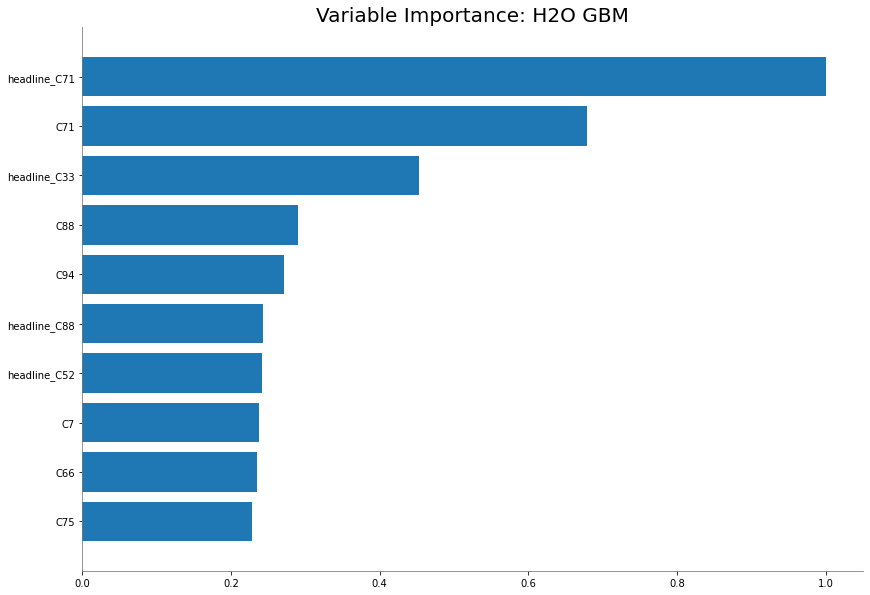

In [53]:
aml.leader.varimp_plot()

# References

* http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
* https://www.kaggle.com/sudalairajkumar/getting-started-with-h2o
* https://github.com/srivatsan88/YouTubeLI/blob/master/H2O_AutoML.ipynb
* https://github.com/srivatsan88/YouTubeLI/blob/master/Sentiment_Analysis_Model_using_GBM_H2O.ipynb